In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python

import io # Input/Output Module
import os # OS interfaces
import cv2 # OpenCV package
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

from urllib import request # module for opening HTTP requests
from matplotlib import pyplot as plt # Plotting library
import seaborn as sns
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import math
import plotly.express as px

<div style="width:100%; height:140px">
    <img src="https://www.kuleuven.be/internationaal/thinktank/fotos-en-logos/ku-leuven-logo.png/image_preview" width = 300px, heigh = auto align=left>
</div>


KUL H02A5a Computer Vision: Group Assignment 1
---------------------------------------------------------------
Student numbers: <span style="color:red">r1, r2, r3, r4, r5</span>.

The goal of this assignment is to explore more advanced techniques for constructing features that better describe objects of interest and to perform face recognition using these features. This assignment will be delivered in groups of 5 (either composed by you or randomly assigned by your TA's).

In this assignment you are a group of computer vision experts that have been invited to ECCV 2021 to do a tutorial about  "Feature representations, then and now". To prepare the tutorial you are asked to participate in a kaggle competition and to release a notebook that can be easily studied by the tutorial participants. Your target audience is: (master) students who want to get a first hands-on introduction to the techniques that you apply.

---------------------------------------------------------------
This notebook is structured as follows:
0. Data loading & Preprocessing
1. Feature Representations
2. Evaluation Metrics 
3. Classifiers
4. Experiments
5. Publishing best results
6. Discussion

Make sure that your notebook is **self-contained** and **fully documented**. Walk us through all steps of your code. Treat your notebook as a tutorial for students who need to get a first hands-on introduction to the techniques that you apply. Provide strong arguments for the design choices that you made and what insights you got from your experiments. Make use of the *Group assignment* forum/discussion board on Toledo if you have any questions.

Fill in your student numbers above and get to it! Good luck! 


<div class="alert alert-block alert-info">
<b>NOTE:</b> This notebook is just a example/template, feel free to adjust in any way you please! Just keep things organised and document accordingly!
</div>

<div class="alert alert-block alert-info">
<b>NOTE:</b> Clearly indicate the improvements that you make!!! You can for instance use titles like: <i>3.1. Improvement: Non-linear SVM with RBF Kernel.<i>
</div>
    
---------------------------------------------------------------
# 0. Data loading & Preprocessing

## 0.1. Loading data
The training set is many times smaller than the test set and this might strike you as odd, however, this is close to a real world scenario where your system might be put through daily use! In this session we will try to do the best we can with the data that we've got! 

In [18]:
# Input data files are available in the read-only "../input/" directory

train = pd.read_csv(
    'train_set.csv', index_col = 0)
train.index = train.index.rename('id')

test = pd.read_csv(
    'test_set.csv', index_col = 0)
test.index = test.index.rename('id')

# read the images as numpy arrays and store in "img" column
train['img'] = [cv2.cvtColor(np.load('train/train/train_{}.npy'.format(index), allow_pickle=False), cv2.COLOR_BGR2RGB) 
                for index, row in train.iterrows()]

test['img'] = [cv2.cvtColor(np.load('test/test/test_{}.npy'.format(index), allow_pickle=False), cv2.COLOR_BGR2RGB) 
                for index, row in test.iterrows()]
  

train_size, test_size = len(train),len(test)

"The training set contains {} examples, the test set contains {} examples.".format(train_size, test_size)

'The training set contains 80 examples, the test set contains 1816 examples.'

*Note: this dataset is a subset of the* [*VGG face dataset*](https://www.robots.ox.ac.uk/~vgg/data/vgg_face/).

## 0.2. A first look
Let's have a look at the data columns and class distribution.

In [19]:
# The training set contains an identifier, name, image information and class label
train.head(1)

name  class                                                img
id                                                                      
0   Mila_Kunis      2  [[[50, 31, 25], [49, 30, 24], [49, 30, 24], [4...

In [20]:
# The test set only contains an identifier and corresponding image information.

test.head(1)

img
id                                                   
0   [[[209, 210, 205], [208, 209, 204], [208, 209,...

In [21]:
# The class distribution in the training set:
train.groupby('name').agg({'img':'count', 'class': 'max'})

img  class
name                       
Jesse_Eisenberg   30      1
Michael_Cera      10      0
Mila_Kunis        30      2
Sarah_Hyland      10      0

Note that **Jesse is assigned the classification label 1**, and **Mila is assigned the classification label 2**. The dataset also contains 20 images of **look alikes (assigned classification label 0)** and the raw images. 

## 0.3. Preprocess data
### 0.3.1 Example: HAAR face detector
In this example we use the [HAAR feature based cascade classifiers](https://opencv-python-tutroals.readthedocs.io/en/latest/py_tutorials/py_objdetect/py_face_detection/py_face_detection.html) to detect faces, then the faces are resized so that they all have the same shape. If there are multiple faces in an image, we only take the first one. 

<div class="alert alert-block alert-info"> <b>NOTE:</b> You can write temporary files to <code>/kaggle/temp/</code> or <code>../../tmp</code>, but they won't be saved outside of the current session
</div>


In [22]:
class HAARPreprocessor():
    """Preprocessing pipeline built around HAAR feature based cascade classifiers. """
    
    def __init__(self, path, face_size):
        self.face_size = face_size
        file_path = os.path.join(path, "haarcascade_frontalface_default.xml")
        if not os.path.exists(file_path): 
            if not os.path.exists(path):
                os.mkdir(path)
            self.download_model(file_path)
        
        self.classifier = cv2.CascadeClassifier(file_path)
  
    def download_model(self, path):
        url = "https://raw.githubusercontent.com/opencv/opencv/master/data/"\
            "haarcascades/haarcascade_frontalface_default.xml"
        
        with request.urlopen(url) as r, open(path, 'wb') as f:
            f.write(r.read())
            
    def detect_faces(self, img):
        """Detect all faces in an image."""
        
        img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        return self.classifier.detectMultiScale(
            img_gray,
            scaleFactor=1.2,
            minNeighbors=5,
            minSize=(30, 30),
            flags=cv2.CASCADE_SCALE_IMAGE
        )
        
    def extract_faces(self, img):
        """Returns all faces (cropped) in an image."""
        
        faces = self.detect_faces(img)

        return [img[y:y+h, x:x+w] for (x, y, w, h) in faces]
    
    def preprocess(self, data_row):
        faces = self.extract_faces(data_row['img'])
        
        # if no faces were found, return None
        if len(faces) == 0:
            nan_img = np.empty(self.face_size + (3,))
            nan_img[:] = np.nan
            return nan_img
        
        # only return the first face
        return cv2.resize(faces[0], self.face_size, interpolation = cv2.INTER_AREA)
            
    def __call__(self, data):
        return np.stack([self.preprocess(row) for _, row in data.iterrows()]).astype(int)

**Visualise**

Let's plot a few examples.

In [23]:
# parameter to play with 
FACE_SIZE = (100, 100)

def plot_image_sequence(data, n, imgs_per_row=7):
    n_rows = math.ceil(n/imgs_per_row)#1 + int(n/(imgs_per_row+1))################# line changed####################
    n_cols = min(imgs_per_row, n)

    f,ax = plt.subplots(n_rows,n_cols, figsize=(10*n_cols,10*n_rows))
    for i in range(n):
        if n == 1:
            ax.imshow(data[i])
        elif n_rows > 1:
            ax[int(i/imgs_per_row),int(i%imgs_per_row)].imshow(data[i])
        else:
            ax[int(i%n)].imshow(data[i])
    plt.show()

    
#preprocessed data 
preprocessor = HAARPreprocessor(path = '../../tmp', face_size=FACE_SIZE)

train_X, train_y = preprocessor(train), train['class'].values
# test_X = preprocessor(test)



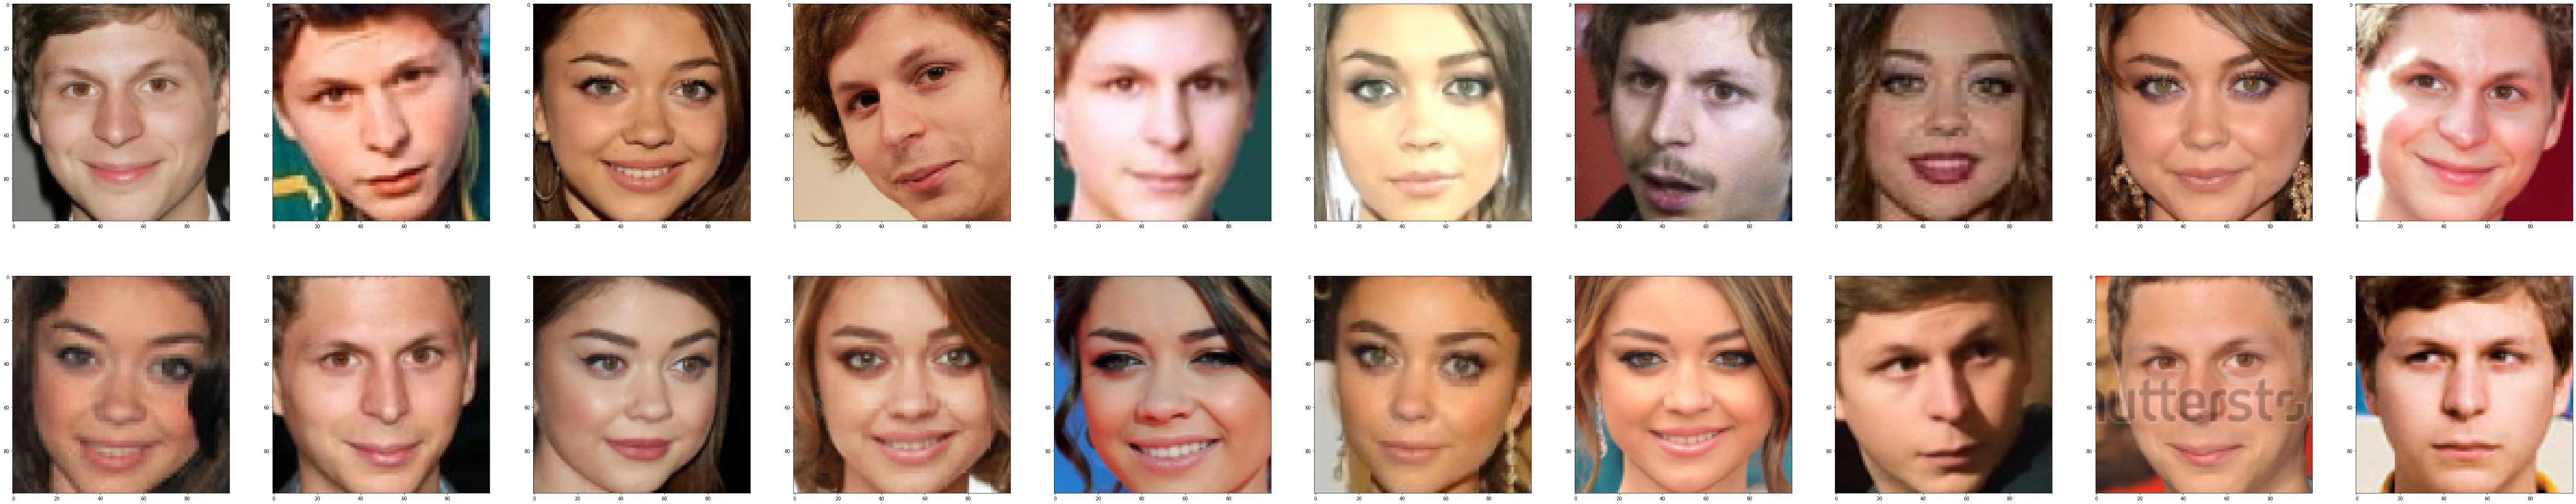

In [8]:
# plot faces of Michael and Sarah

plot_image_sequence(train_X[train_y == 0], n=20, imgs_per_row=10)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


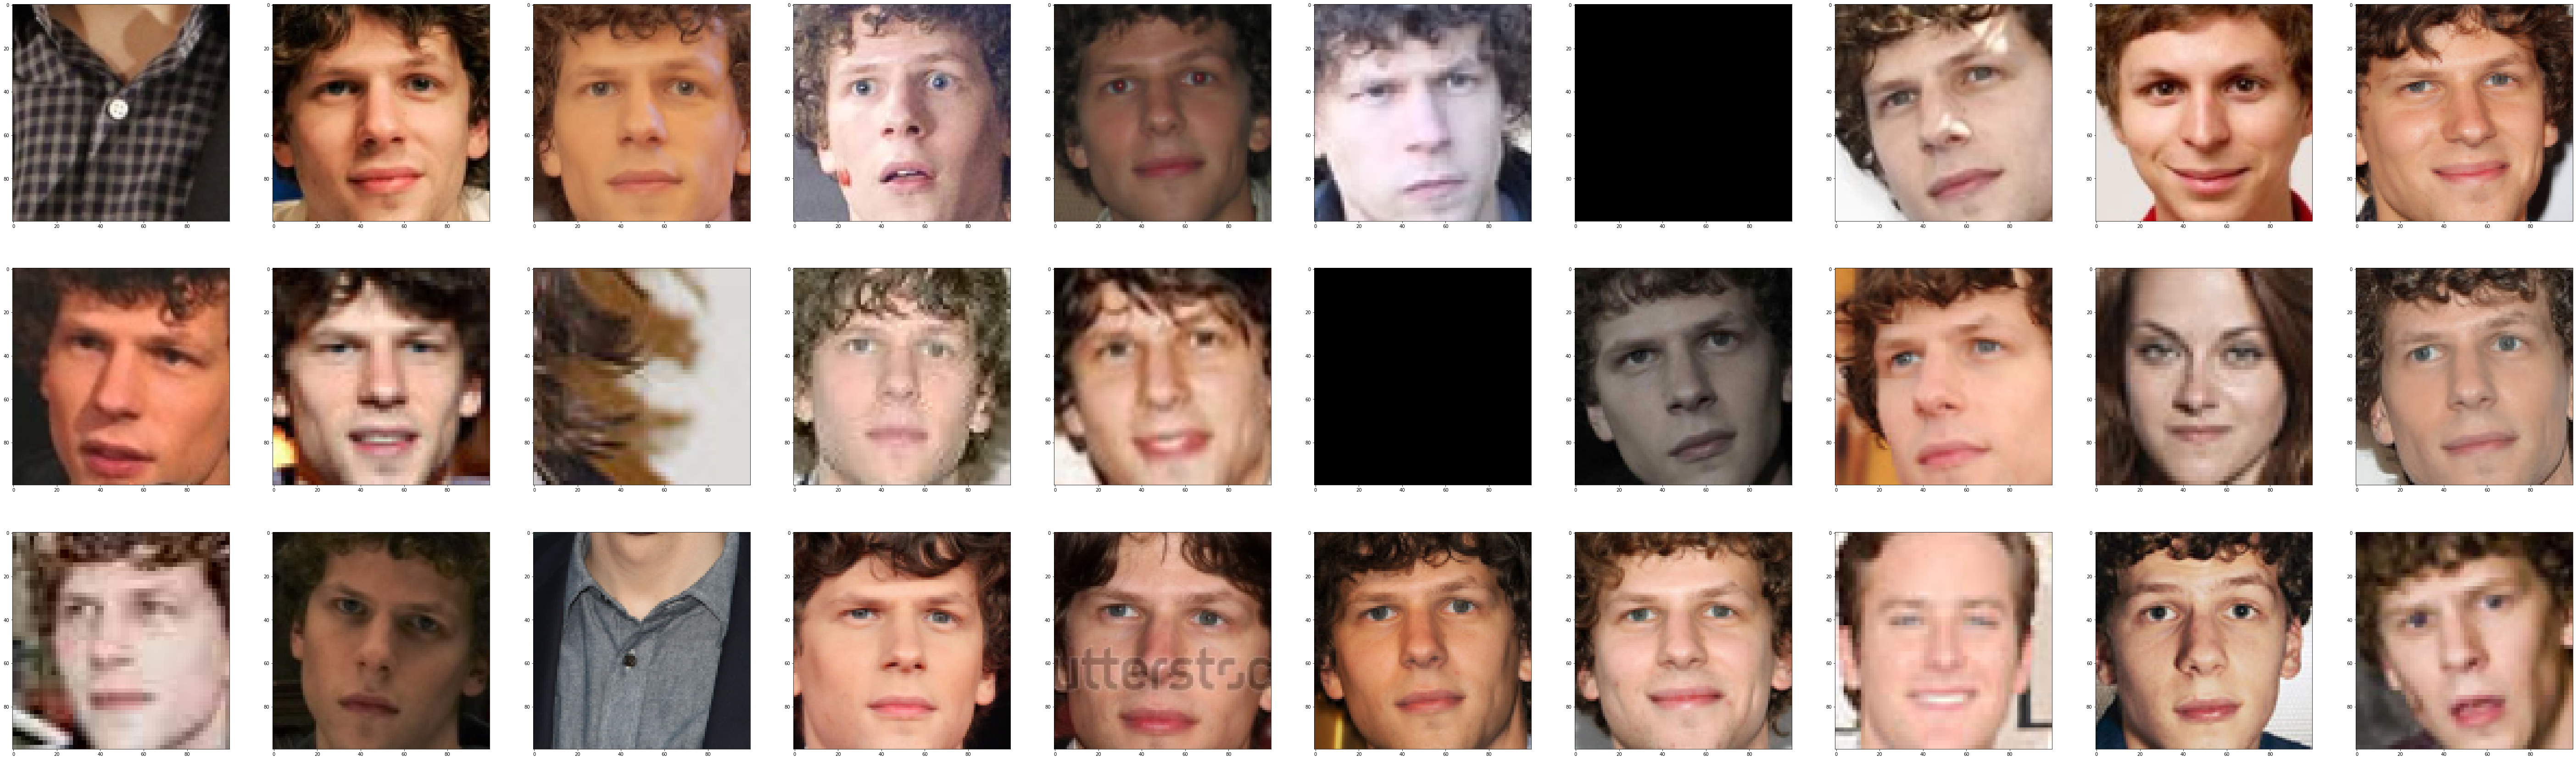

In [9]:
# plot faces of Jesse

plot_image_sequence(train_X[train_y == 1], n=30, imgs_per_row=10)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


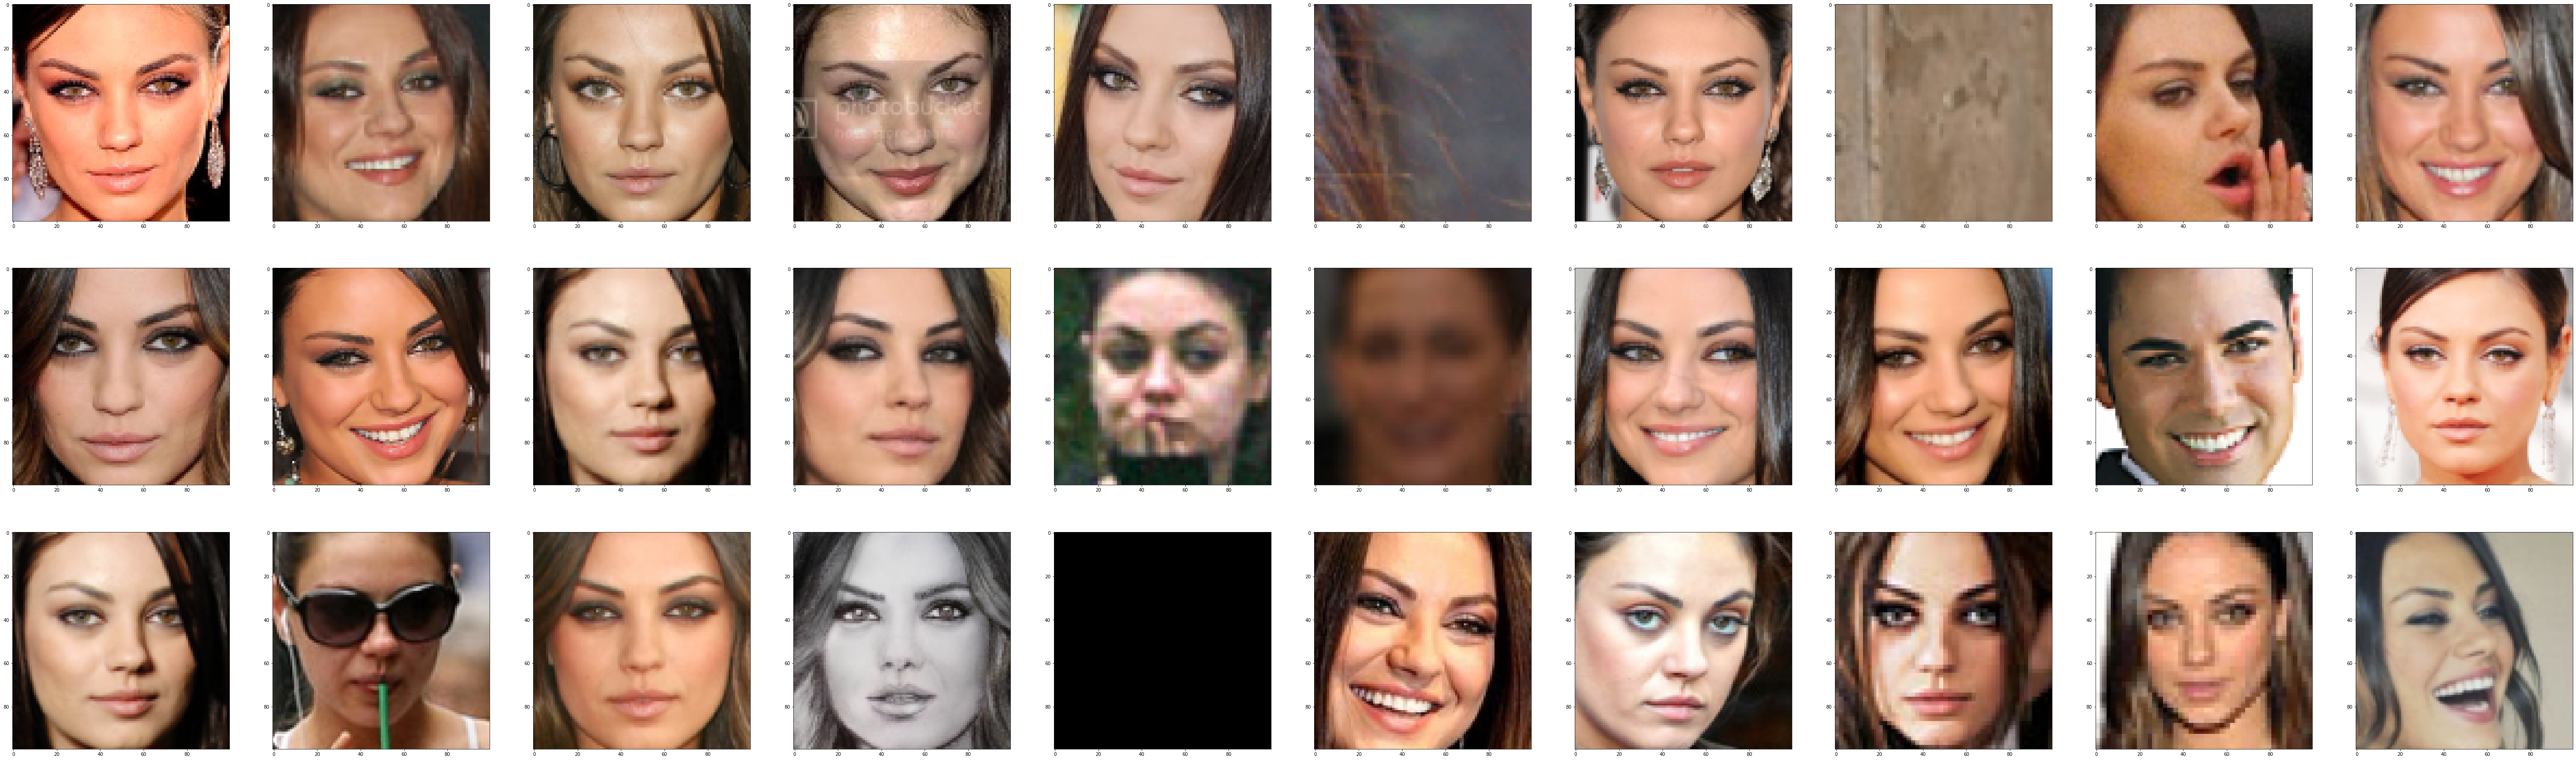

In [10]:
# plot faces of Mila

plot_image_sequence(train_X[train_y == 2], n=30, imgs_per_row=10)

In [36]:
# Array of cleaned dataset with Jesse images
train_Jesse_clean = np.delete(train_X[train_y == 1], (0,6,8,12,15,18,22,27), axis=0)
print(train_Jesse_clean.shape)

# Array of cleaned dataset with Mila images
train_Mila_clean = np.delete(train_X[train_y == 2], (5,7,14,15,18,21,24), axis=0)
print(train_Mila_clean.shape)

(22, 100, 100, 3)
(23, 100, 100, 3)


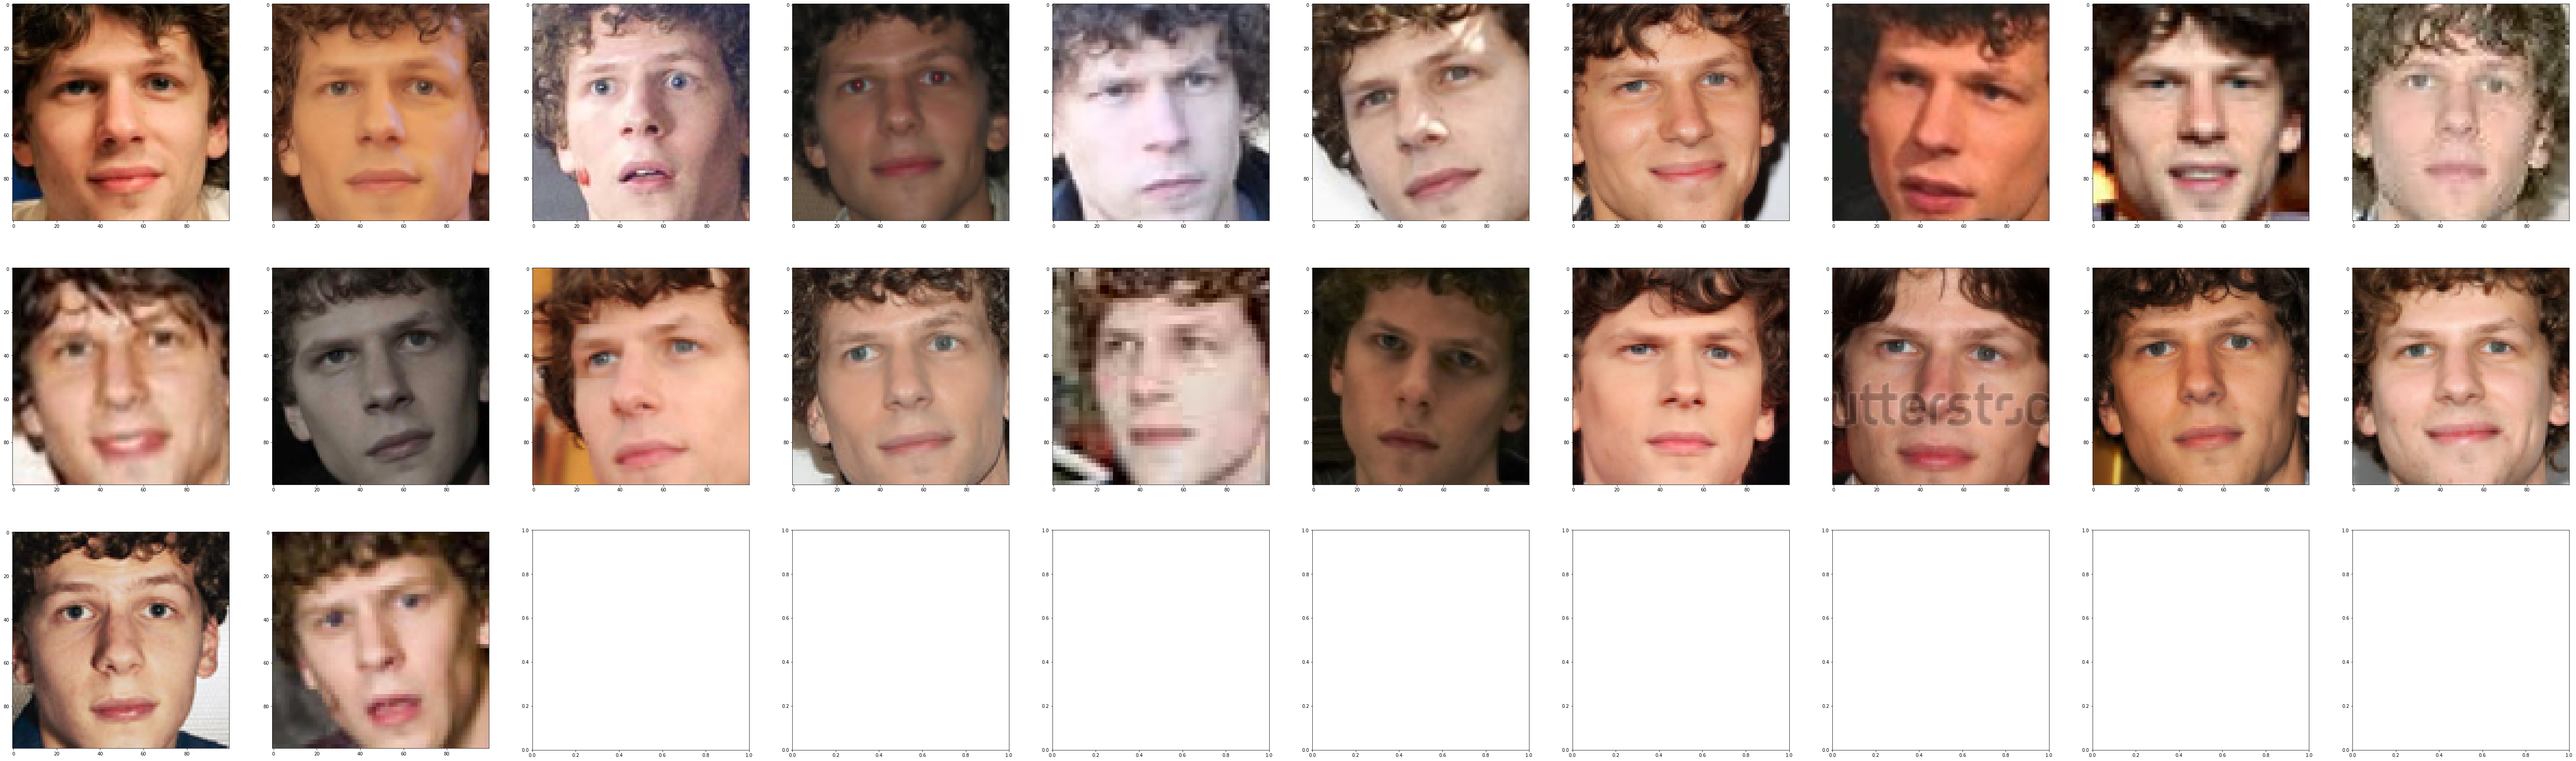

In [12]:
# plot of cleaned dataset with faces of Jesse
plot_image_sequence(train_Jesse_clean, train_Jesse_clean.shape[0], imgs_per_row=10)

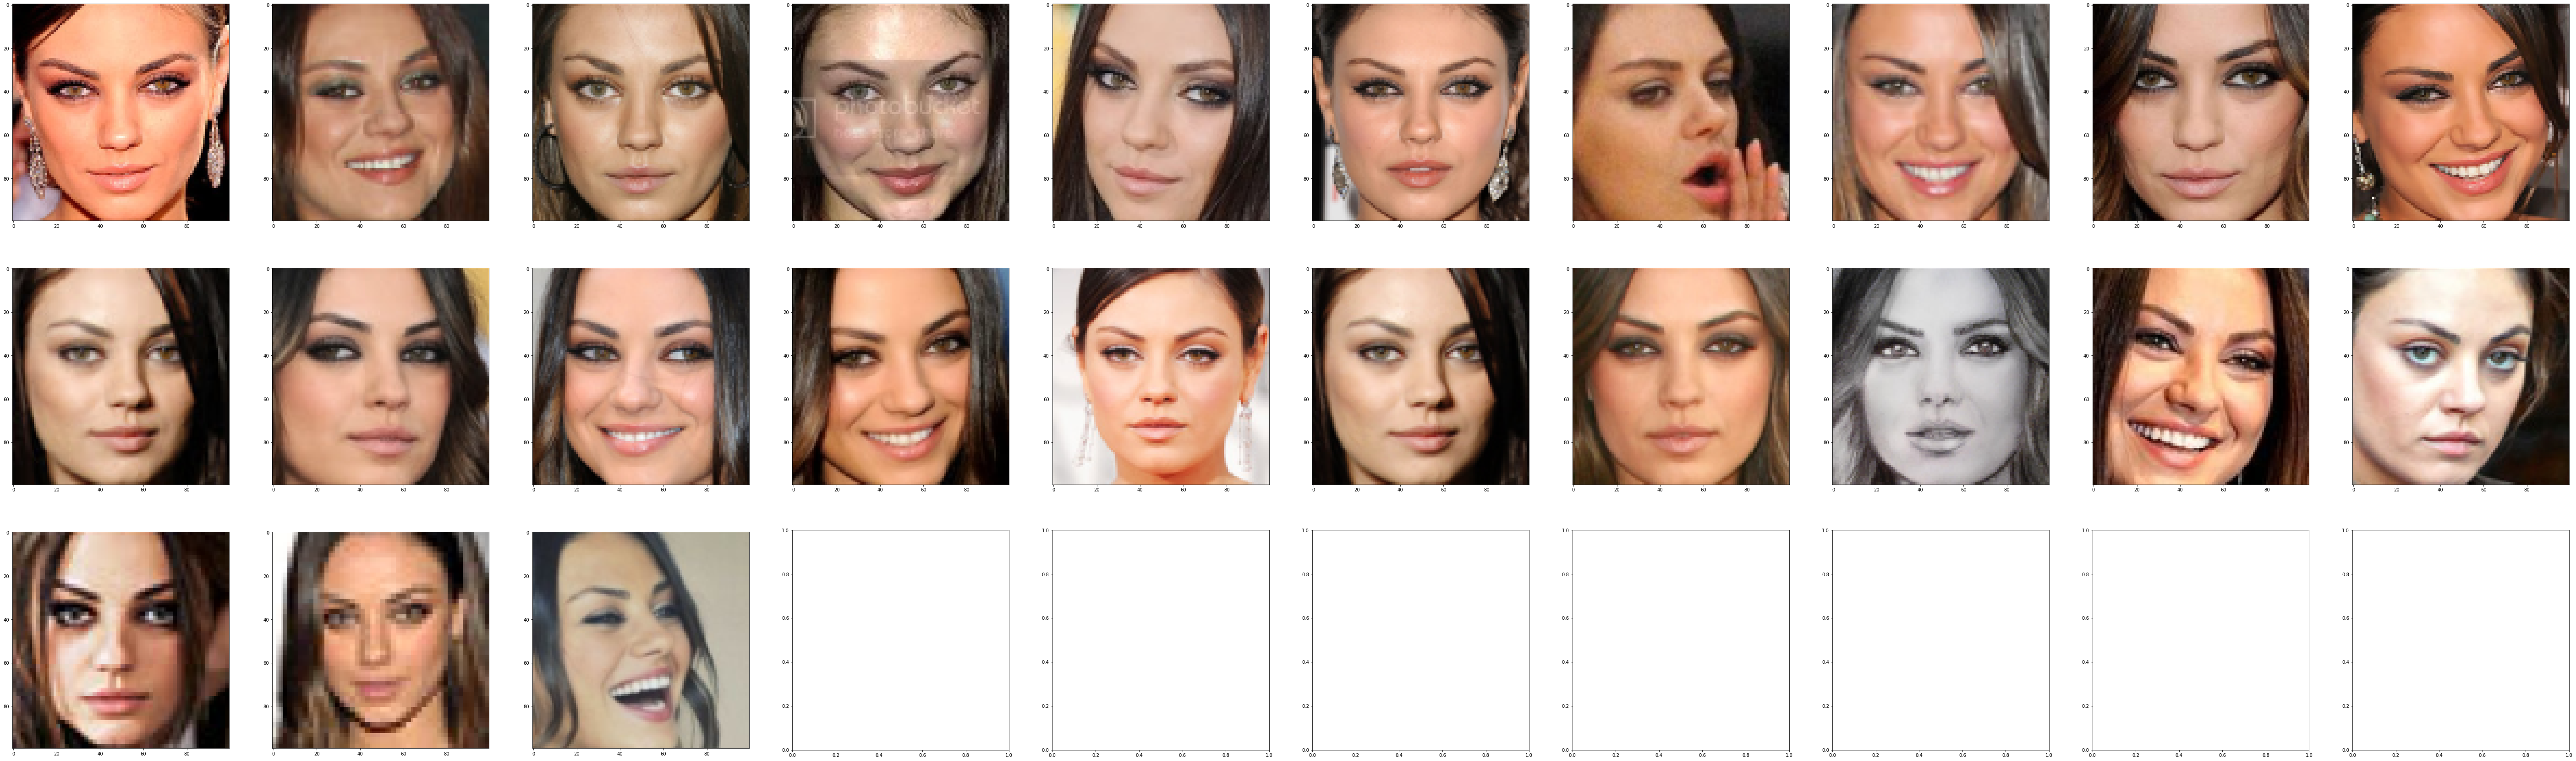

In [13]:
# plot of cleaned dataset with faces of Mila
plot_image_sequence(train_Mila_clean, train_Mila_clean.shape[0], imgs_per_row=10)

In [37]:
#Combining all images to a single array
train_X_stack = np.vstack((train_X[train_y==0],train_Jesse_clean, train_Mila_clean)) 
train_y_stack = np.vstack((np.zeros([train_X[train_y==0].shape[0],1]), np.ones([train_Jesse_clean.shape[0],1]), 
                           np.ones([train_Mila_clean.shape[0],1])*2))
print(train_X_stack.shape,train_y_stack.shape)

(65, 100, 100, 3) (65, 1)


## 0.4. Store Preprocessed data (optional)
<div class="alert alert-block alert-info">
<b>NOTE:</b> You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All". Feel free to use this to store intermediary results.
</div>

In [15]:
# save preprocessed data
# prep_path = '/kaggle/working/prepped_data/'
# if not os.path.exists(prep_path):
#     os.mkdir(prep_path)
    
# np.save(os.path.join(prep_path, 'train_X.npy'), train_X)
# np.save(os.path.join(prep_path, 'train_y.npy'), train_y)
# np.save(os.path.join(prep_path, 'test_X.npy'), test_X)

# load preprocessed data
# prep_path = '/kaggle/working/prepped_data/'
# if not os.path.exists(prep_path):
#     os.mkdir(prep_path)
# train_X = np.load(os.path.join(prep_path, 'train_X.npy'))
# train_y = np.load(os.path.join(prep_path, 'train_y.npy'))
# test_X = np.load(os.path.join(prep_path, 'test_X.npy'))

Now we are ready to rock!

# 1. Feature Representations
## 1.0. Example: Identify feature extractor
Our example feature extractor doesn't actually do anything... It just returns the input:
$$
\forall x : f(x) = x.
$$

It does make for a good placeholder and baseclass ;).

In [16]:
class IdentityFeatureExtractor:
    """A simple function that returns the input"""
    
    def transform(self, X):
        return X
    
    def __call__(self, X):
        return self.transform(X)



## 1.1. Baseline 1: HOG feature extractor/Scale Invariant Feature Transform
...

In [17]:
from skimage.feature import hog
from skimage import exposure

class HOGFeatureExtractor(IdentityFeatureExtractor):
    
    def __init__(self, orientations=9, pixels_per_cell=(20, 20), cells_per_block=(1, 1),
                visualize=False, multichannel=True): 
        
        self.orientations = orientations
        self.pixels_per_cell = pixels_per_cell
        self.cells_per_block = cells_per_block
        self.visualize = visualize
        self.multichannel = multichannel
      
    def transform(self, X):
        X = cv2.GaussianBlur(np.uint8(X), (5,5), cv2.BORDER_DEFAULT)
        return hog(X, orientations=self.orientations, pixels_per_cell = self.pixels_per_cell,
                cells_per_block = self.cells_per_block, visualize = self.visualize, 
                   multichannel = self.multichannel)

KeyboardInterrupt: 

In [ ]:
img = train_Mila_clean[0,:,:,:]

myhog2 = HOGFeatureExtractor(orientations=9, pixels_per_cell=(10, 10), cells_per_block=(1, 1),
                visualize=True, multichannel=True)
fd, hog_image = myhog2(img)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4), sharex=True, sharey=True)
ax1.axis('off')
ax1.imshow(img, cmap=plt.cm.gray)
ax1.set_title('Input image')

# Rescale histogram for better display
hog_image_rescaled = exposure.rescale_intensity(hog_image, in_range=(0, 255))
ax2.axis('off')
ax2.imshow(hog_image_rescaled, cmap=plt.cm.gray)
ax2.set_title('Histogram of Oriented Gradients')
plt.show()
print(fd.shape)



In [ ]:
#Initializong HOG extractor
Myhog = HOGFeatureExtractor(orientations=9, pixels_per_cell=(10,10), cells_per_block=(1, 1),
                visualize=False, multichannel=True)

print(train_X_stack.shape)
#Feature vector of entire dataset
fd_total = np.stack([Myhog(train_X_stack[i]) for i in range(train_X_stack.shape[0])])    
print(fd_total.shape)

In [ ]:
'''
class SIFTFeatureExtractor(IdentityFeatureExtractor):
      
    #def __init__(self):
        
        
    def transform(self, X):
        gray = cv2.cvtColor(X, cv2.COLOR_BGR2GRAY)
        gray = cv2.GaussianBlur(gray, (5,5), cv2.BORDER_DEFAULT)
        ## RESIZE
        nr_of_kp = 5 #number of key points to be detected
        sift = cv2.SIFT_create(nr_of_kp, 5, 0.07, 3, 0.8)
        kp, descr = sift.detectAndCompute(gray, None)
        kp = kp[0:nr_of_kp] #maintaining only a specific number of keypoints
        descr = descr[0:len(kp),:] #maintaining corresponding descriptors
        cv2.drawKeypoints(X,kp,X)
        return descr.flatten()

#Testing SIFT on an image
%matplotlib inline
sift = SIFTFeatureExtractor()
im_example = np.uint8(train_Mila_clean[1,:,:,:])
descr_example = sift(im_example)
print(descr_example.shape)
plt.imshow(im_example)
plt.title('SIFT test')
plt.show()

def evaluate_matching_predictors(list_descriptor):
    bf = cv2.BFMatcher(cv2.NORM_L1, crossCheck=True)
    scores = []
    for i,d in enumerate(list_descriptor):
        score = [len(bf.match(d,other_descr))/len(d) for j,other_descr in enumerate(list_descriptor) if i != j]
        scores.append(np.mean(score))
    return scores


%matplotlib inline
Mila = np.uint8(np.zeros(train_Mila_clean.shape))
Jesse = np.uint8(np.zeros(train_Jesse_clean.shape))

#####Note########
# I am using the arrays Jesse, Mila instead of train_X_Mila, train_X_Jesse 
# due to the fact that the SIFT function as I have impleneted it currently 
#modifies(draws circles) the images that it accepts as input (probably will change)
#################


# initial values used for the stacking (see vstack below)
Mila[0] = train_Mila_clean[0] 
features_Mila = [list(sift(Mila[0]))]
Jesse[0] = train_Jesse_clean[0]
features_Jesse = [list(sift(Jesse[0]))]

#Capturing Mila features
descr_Mila = []
for i in range(train_Mila_clean.shape[0]-1):
    Mila[i+1] = train_Mila_clean[i+1]
    descriptor = sift(Mila[i+1])
    descr_Mila.append(descriptor)
    # features_Mila = np.concatenate((features_Mila, descriptor), axis = 0)
    #print(descriptor)
    features_Mila.append(list(descriptor))

#Capturing Jesse features
descr_Jesse = []
for i in range(train_Jesse_clean.shape[0]-1):
    Jesse[i+1] = train_Jesse_clean[i+1]
    descriptor = sift(Jesse[i+1])
    descr_Jesse.append(descriptor)
    # features_Jesse = np.concatenate((features_Jesse, descriptor), axis = 0)
    features_Jesse.append(list(descriptor))
    
scores_Mila = evaluate_matching_predictors(descr_Mila)
scores_Jesse = evaluate_matching_predictors(descr_Jesse)
print(f"Mila matching score: {np.mean(scores_Mila)}")
print(f"Jesse matching score: {np.mean(scores_Jesse)}")

    
#Plotting entire dataset with keypoints drawn on images  
plot_image_sequence(Mila, Mila.shape[0], imgs_per_row=10)
plot_image_sequence(Jesse, Jesse.shape[0], imgs_per_row=10)
'''

### 1.1.1. t-SNE Plots
...

In [ ]:
#t-SNE viisualization
tsne = TSNE(n_components=2, perplexity=7).fit_transform(fd_total)
features_df = pd.DataFrame(tsne, columns =['dimension 1','dimension 2'])
features_df['Faces'] = train_y_stack
sns.scatterplot(data=features_df, x='dimension 1', y='dimension 2', hue='Faces')
plt.title('t-SNE plot')
plt.show()


### 1.1.2. Discussion
...

## 1.2. Baseline 2: PCA feature extractor
...

In [ ]:
class PCAFeatureExtractor(IdentityFeatureExtractor):
    
    def __init__(self, n_components):
        self.n_components = n_components
        self.pca = PCA(n_components = n_components)
        
    def transform(self, X):
        return self.pca.fit_transform(X)
        
    def inverse_transform(self, X):
        return self.pca.inverse_transform(X)
    
    def variance_ratio(self):
        return self.pca.explained_variance_ratio_

### 1.2.1. Eigenface Plots
...

In [ ]:
nr_of_components = [1, 2, 5, 10, 20, 30,40, 62] #Components chosen for the plots
fig, ax = plt.subplots(2, len(nr_of_components), figsize=(20,7))
train_X_flat = train_X_stack.reshape(train_X_stack.shape[0],-1)
#Plot gradual reconstruction of faces
for i in range(len(nr_of_components)):
    #Using PCA to Project the data
    pca = PCAFeatureExtractor(nr_of_components[i])
    proj_data = pca(train_X_flat)
    rec_data = pca.inverse_transform(proj_data).reshape(-1,FACE_SIZE[0],FACE_SIZE[1],3)
    rec_data = cv2.normalize(rec_data, None, 0, 255, cv2.NORM_MINMAX, cv2.CV_8U)
    #Plotting Jesse's faces
    ax[0,i].imshow(rec_data[50])
    ax[0,i].set_xticks([])
    ax[0,i].set_yticks([])
    ax[0,i].set_title(f'p = {nr_of_components[i]}')   
    #Plotting Mila's faces
    ax[1,i].imshow(rec_data[38])
    ax[1,i].set_xticks([])
    ax[1,i].set_yticks([])
    ax[1,i].set_title(f'p = {nr_of_components[i]}')

In [ ]:
pca = PCAFeatureExtractor(train_X_flat.shape[0])
projected_data = pca(train_X_flat)
plt.figure(figsize=(8,6))
plt.plot(pca.variance_ratio().cumsum())
plt.xlabel('number of principal components')
plt.ylabel('total variance ratio')
plt.show()

### 1.2.2. Feature Space Plots
...

In [ ]:
df = pd.DataFrame(data = projected_data[:,0:2], columns = ['p1', 'p2'])
df['faces'] = train_y_stack

plt.figure(figsize=(8,6))
sns.scatterplot(data=df, x='p1', y='p2', hue='faces', legend=True);
plt.title('Faces projections on the first two principal components')
plt.legend(title='Faces', loc='upper left')
plt.show()

### 1.2.3. Discussion
...

# 2. Evaluation Metrics
## 2.0. Example: Accuracy
As example metric we take the accuracy. Informally, accuracy is the proportion of correct predictions over the total amount of predictions. It is used a lot in classification but it certainly has its disadvantages...

In [ ]:
from sklearn.metrics import accuracy_score

# 3. Classifiers
## 3.0. Example: The *'not so smart'* classifier
This random classifier is not very complicated. It makes predictions at random, based on the distribution obseved in the training set. **It thus assumes** that the class labels of the test set will be distributed similarly to the training set.

Analyzing the images that are wrongly classified usign HOG features it can be noticed that they mostly belong to the class 0. The reason is that this class is poorly represented with respect to the other two and it contains disomogeneous data. The consequence is that, while the recall for the classes 2 and 3 is close to 1, the precision is strongly affected.

In [32]:
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from numpy import mean, std

def classify(X, classifier, y = train_y_stack, data = train_X_stack):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
    classifier.fit(X_train,y_train)
    preds = classifier.predict(X_test)
    accuracy = accuracy_score(y_test,preds)
    print(f"Accuracy with train test split: {accuracy}\n")
    cv = KFold(n_splits=5, shuffle=True)
    preds = cross_val_predict(classifier, X, y, cv=cv, n_jobs=-1)
    accuracy = accuracy_score(y,preds)
    print('Accuracy with k-fold cross validation: %.3f\n' % (accuracy))
    mistakes = [data[i] for i in range(len(preds)) if y[i] != preds[i]]
    mistakes_labels = [preds[i] for i in range(len(preds)) if y[i] != preds[i]]
    plot_image_sequence(mistakes, len(mistakes), imgs_per_row=10)
    print("Labels: ")
    print(mistakes_labels)
    
    



NameError: name 'train_y_stack' is not defined

The best performance are reached by SVC and KNeighborsClassifier (better expecially using PCA components as features).

In [ ]:
# Classification basing on HOG features extractor
classifier = KNeighborsClassifier()
classify(fd_total,classifier)
print("\n\n")
# Classification basing on PCA
print(projected_data[:, :40].shape)
classify(projected_data[:, :40], classifier)


In [ ]:
class RandomClassificationModel:
    """Random classifier, draws a random sample based on class distribution observed 
    during training."""
    
    def fit(self, X, y):
        """Adjusts the class ratio instance variable to the one observed in y. 

        Parameters
        ----------
        X : tensor
            Training set
        y : array
            Training set labels

        Returns
        -------
        self : RandomClassificationModel
        """
        
        self.classes, self.class_ratio = np.unique(y, return_counts=True)
        self.class_ratio = self.class_ratio / self.class_ratio.sum()
        return self
        
    def predict(self, X):
        """Samples labels for the input data. 

        Parameters
        ----------
        X : tensor
            dataset
            
        Returns
        -------
        y_star : array
            'Predicted' labels
        """

        np.random.seed(0)
        return np.random.choice(self.classes, size = X.shape[0], p=self.class_ratio)
    
    def __call__(self, X):
        return self.predict(X)
    

## 3.1. Baseline 1: My favorite classifier
...

In [ ]:
class FavoriteClassificationModel:
    """TODO: this classifier is under construction."""
    
    def fit(self, X, y):
        raise NotImplmentedError
        
    def predict(self, X):
        raise NotImplmentedError

# 4. Experiments
<div class="alert alert-block alert-info"> <b>NOTE:</b> Do <i>NOT</i> use this section to keep track of every little change you make in your code! Instead, highlight the most important findings and the major (best) pipelines that you've discovered.  
</div>
<br>

## 4.0. Example: basic pipeline
The basic pipeline takes any input and samples a label based on the class label distribution of the training set. As expected the performance is very poor, predicting approximately 1/4 correctly on the training set. There is a lot of room for improvement but this is left to you ;). 

In [ ]:
feature_extractor = IdentityFeatureExtractor() 
classifier = RandomClassificationModel()

# train the model on the features
classifier.fit(feature_extractor(train_X), train_y)

# model/final pipeline
model = lambda X: classifier(feature_extractor(X))

In [ ]:
# evaluate performance of the model on the training set
train_y_star = model(train_X)

"The performance on the training set is {:.2f}. This however, does not tell us much about the actual performance (generalisability).".format(
    accuracy_score(train_y, train_y_star))

In [ ]:
#Initializong HOG extractor
print(test_X.shape)
Myhog = HOGFeatureExtractor(orientations=9, pixels_per_cell=(10,10), cells_per_block=(1, 1),
                visualize=False, multichannel=True)

#Feature vector of entire dataset
test_HOG = np.stack([Myhog(test_X[i]) for i in range(test_X.shape[0])])    
print(fd_total.shape)

In [ ]:
plot_image_sequence(test_X, len(test_X[0]), imgs_per_row=10)


In [ ]:
# predict the labels for the test set 
#test_y_star = model(test_X)
classifier = KNeighborsClassifier()
classifier.fit(fd_total,train_y_stack)
test_y_star = classifier.predict(test_HOG)
print(test_y_star)
#test_y_star = model(test_X)

## CNN implementation

In [41]:
test_X = preprocessor(test)

In [46]:
test_labels = np.genfromtxt('true_labels.csv',delimiter=',')
test_labels[0] = 1
test_labels

array([1., 0., 0., ..., 1., 0., 0.])

In [ ]:
onehot_encoder = OneHotEncoder(sparse=False)
integer_encoded = train_y_stack.reshape(len(train_y_stack), 1)
onehot_y = onehot_encoder.fit_transform(integer_encoded)

In [72]:
from keras.preprocessing.image import ImageDataGenerator
# create image data augmentation generator
datagen = ImageDataGenerator(brightness_range=[0.2,1.0])
# prepare iterator
it = datagen.flow(train_X_stack, onehot_y, batch_size=3)


In [73]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Dropout, Flatten
from sklearn.preprocessing import OneHotEncoder

def createModel():
    model = Sequential()
    # The first two layers with 32 filters of window size 3x3
    model.add(Conv2D(32, (3, 3), padding='same', activation='relu', input_shape=(100,100,3)))
    model.add(Conv2D(32, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    model.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    model.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    model.add(Flatten())
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(3, activation='softmax'))
    
    return model

X_train, X_val, y_train, y_val = train_test_split(train_X_stack, onehot_y, test_size=0.3)
# Initialize the model
model1 = createModel()

# Set training process params
batch_size = 3
epochs = 50

# Set the training configurations: optimizer, loss function, accuracy metrics
model1.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

# Model -> 66.5% accuracy
history = model1.fit(train_X_stack,
                     onehot_y,
                     batch_size=batch_size, 
                     epochs=epochs, verbose=1, 
                     validation_data=(X_val, y_val)
          )



Epoch 1/50
22/22 [==============================] - 3s 110ms/step - loss: 61.0329 - accuracy: 0.3614 - val_loss: 1.0918 - val_accuracy: 0.5000
Epoch 2/50
22/22 [==============================] - 2s 104ms/step - loss: 1.3289 - accuracy: 0.3797 - val_loss: 1.1026 - val_accuracy: 0.2000
Epoch 3/50
22/22 [==============================] - 2s 106ms/step - loss: 2.1690 - accuracy: 0.3845 - val_loss: 1.0940 - val_accuracy: 0.4000
Epoch 4/50
22/22 [==============================] - 2s 102ms/step - loss: 2.7389 - accuracy: 0.4300 - val_loss: 1.0880 - val_accuracy: 0.7500
Epoch 5/50
22/22 [==============================] - 2s 102ms/step - loss: 1.5184 - accuracy: 0.4053 - val_loss: 1.0026 - val_accuracy: 0.6000
Epoch 6/50
22/22 [==============================] - 2s 101ms/step - loss: 1.2641 - accuracy: 0.4371 - val_loss: 1.0335 - val_accuracy: 0.3000
Epoch 7/50
22/22 [==============================] - 2s 104ms/step - loss: 1.2007 - accuracy: 0.4186 - val_loss: 0.9369 - val_accuracy: 0.6500
Epoch

In [ ]:
# Model with data augmentation -> 70.4% accuracy with brightness_range=[0.2,1.0]
history = model1.fit(it,
                     steps_per_epoch=len(train_X_stack)/3, 
                     epochs=epochs
          )

In [74]:
# Check the model results on the test set
integer_encoded = test_labels.reshape(len(test_labels), 1)
onehot_labels = onehot_encoder.fit_transform(integer_encoded)
model1.evaluate(test_X, onehot_labels)

57/57 [==============================] - 9s 152ms/step - loss: 299878.5938 - accuracy: 0.6993


[299878.59375, 0.6993392109870911]

# 5. Publishing best results

In [ ]:
submission = test.copy().drop('img', axis = 1)
submission['class'] = [int(x) for x in test_y_star]

submission

In [ ]:
submission.to_csv('submission.csv')

# 6. Discussion
...

In summary we contributed the following: 
* 
